In [ ]:
!nvidia-smi

Fri Mar 11 05:55:49 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   32C    P8    29W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
import matplotlib.pyplot as plt
from PIL import Image
import torch.nn as nn
import numpy as np
import os, json

import torch
from torchvision import models, transforms
from torch.autograd import Variable
import torch.nn.functional as F

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# drive.flush_and_unmount()

In [ ]:
# !ls
# # !rm -r /content/posters/
# !cp -r drive/MyDrive/posters/ posters/

drive  posters	sample_data


In [ ]:
!rm -r posters

In [ ]:
!cp drive/MyDrive/posters.zip .
!cp drive/MyDrive/label_movieid_map.csv .
!unzip -qq posters.zip -d .

In [ ]:
meow = os.listdir("posters")
print(len(meow))

35994


In [ ]:
x = os.listdir('posters')
x = [int(i.split('.')[0]) for i in x]
print(x)

[2302966, 23838, 99127, 114502, 856778, 1483803, 3504824, 1567130, 1131729, 1343394, 112483, 926763, 2626962, 69449, 298130, 93870, 211465, 1121977, 1712187, 406158, 92099, 104507, 120684, 1216492, 2064968, 3922754, 80297, 398883, 63483, 1981107, 1821680, 162243, 2058617, 181396, 76502, 303929, 65775, 1337589, 213121, 78251, 805526, 1740053, 3384870, 326036, 808265, 49475, 3665860, 422091, 9652, 2082197, 73580, 3671676, 118641, 81470, 316788, 78952, 374102, 119194, 352426, 42830, 43678, 2095657, 161215, 120823, 2835548, 167046, 68805, 856052, 36940, 117093, 272118, 100196, 1033643, 39260, 400426, 74475, 54768, 3674410, 356443, 2555302, 23337, 41278, 4060576, 67526, 2382298, 4834762, 1346965, 109474, 141716, 109381, 342272, 4065308, 190332, 1129396, 74454, 51083, 302309, 325980, 111309, 33517, 3092606, 3082826, 284534, 30469, 159535, 4621642, 86420, 4601102, 89997, 63522, 20336, 1562450, 69768, 312278, 39031, 424434, 3616916, 142342, 924510, 113280, 282515, 104905, 2383616, 2673674, 345

In [ ]:
# run this cell if not downloaded the csv files else run the cell below this one
import pandas as pd
temp = pd.read_csv("/content/label_movieid_map.csv")
temp = temp[temp.movieid.isin(x)]
trainLabelMovieMap = temp.iloc[:int(0.7*len(temp)),:]
testLabelMovieMap= temp.iloc[int(0.7*len(temp)):int(0.9*len(temp)),:]
valLabelMovieMap = temp.iloc[int(0.9*len(temp)):,:]
trainLabelMovieMap.to_csv('trainLabelMovieMap.csv')
testLabelMovieMap.to_csv('testLabelMovieMap.csv')
valLabelMovieMap.to_csv('valLabelMovieMap.csv')

In [ ]:
#un this cell if downlaoded csv files
import pandas as pd
trainLabelMovieMap = pd.read_csv("/content/trainLabelMovieMap.csv")
testLabelMovieMap = pd.read_csv("/content/testLabelMovieMap.csv")
valLabelMovieMap = pd.read_csv("/content/valLabelMovieMap.csv")

In [ ]:
!ls
# %cd ..
!ls

drive		       posters.zip	      trainLabelMovieMap.csv
label_movieid_map.csv  sample_data	      valLabelMovieMap.csv
posters		       testLabelMovieMap.csv
drive		       posters.zip	      trainLabelMovieMap.csv
label_movieid_map.csv  sample_data	      valLabelMovieMap.csv
posters		       testLabelMovieMap.csv


In [ ]:
from torch.utils.data import Dataset, DataLoader
# from skimage import io, transform
import numpy as np
import matplotlib.pyplot as plt
import cv2
from PIL import Image
from torchvision.datasets.folder import pil_loader

class MoviesTrainDataset(Dataset):
    """Face Landmarks dataset."""

    def __init__(self,traindatadir, transform=None):
        """
        Args:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        super(MoviesTrainDataset, self).__init__()
        self.someData = pd.read_csv(traindatadir)
        self.root_dir = "/content/posters"
        self.transform = transform

    def __len__(self):
        return len(self.someData)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        img_name = os.path.join(self.root_dir,str(self.someData.iloc[idx, -1])+".jpg")
        # image = cv2.imread(img_name)
        # image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
        image = pil_loader(img_name)
        labels = self.someData.iloc[idx, 2:-2].values

        if self.transform:
            image = self.transform(image)
            # labels = self.transform(labels)
        # sample = {"image":image,"label":labels}
        labels = labels.astype('int')
        
        return image, labels

class MoviesTestDataset(Dataset):
    """Face Landmarks dataset."""

    def __init__(self, testdatadir, transform=None):
        """
        Args:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        super(MoviesTestDataset, self).__init__()
        self.someData = pd.read_csv(testdatadir)
        self.root_dir = "/content/posters/"
        self.transform = transform

    def __len__(self):
        return len(self.someData)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        img_name = os.path.join(self.root_dir,
                                str(self.someData.iloc[idx, -1])+".jpg")
        # image = io.imread(img_name)
        image = pil_loader(img_name)
        labels = self.someData.iloc[idx, 2:-2].values
        if self.transform:
            image = self.transform(image)
        labels = labels.astype('int')
        
        return image, labels

class MoviesValDataset(Dataset):
    """Face Landmarks dataset."""

    def __init__(self, valdatadir, transform=None):
        """
        Args:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        super(MoviesValDataset, self).__init__()
        self.someData = pd.read_csv(valdatadir)
        self.root_dir = "/content/posters/"
        self.transform = transform

    def __len__(self):
        return len(self.someData)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        img_name = os.path.join(self.root_dir,
                                str(self.someData.iloc[idx, -1])+".jpg")
        # image = io.imread(img_name)
        image = pil_loader(img_name)
        labels = self.someData.iloc[idx, 2:-2].values
        if self.transform:
            image = self.transform(image)

        labels = labels.astype('int')
        
        return image, labels

In [ ]:
# transform = transforms.Compose([transforms.ToTensor()])
#calc mean of the dataset on ur own
transform = transforms.Compose([transforms.Resize((256, 256)),transforms.CenterCrop(224),transforms.ToTensor(),transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225])])
trainData = MoviesTrainDataset("/content/trainLabelMovieMap.csv",transform)
# print(trainData[0])
testData = MoviesTestDataset("/content/testLabelMovieMap.csv",transform)
valData = MoviesValDataset("/content/valLabelMovieMap.csv",transform)

In [ ]:
trainloader = DataLoader(
        trainData,
        batch_size=32,
        shuffle=True,
        pin_memory=torch.cuda.is_available()
    )
testloader = DataLoader(
        testData,
        batch_size=32,
        shuffle=True,
        pin_memory=torch.cuda.is_available()
    )
valloader = DataLoader(
        valData,
        batch_size=32,
        shuffle=True,
        pin_memory=torch.cuda.is_available()
    )

In [ ]:
blah =iter(trainloader)
!ls
batch = next(blah)

drive		       posters.zip	      trainLabelMovieMap.csv
label_movieid_map.csv  sample_data	      valLabelMovieMap.csv
posters		       testLabelMovieMap.csv


In [ ]:
print(batch[1])

tensor([[0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0],
        [0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0],
        [0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 1, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0],
        [0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0],
        [0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0],
        [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0

In [ ]:
print(len(trainloader))

788


In [ ]:
import torchvision.models as models
inception = models.resnet50(pretrained=True)


In [ ]:
print(inception)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [ ]:
for children in inception.children():
    # children.requires_grad = False
    for child in children.parameters():
      child.requires_grad = True
      # child.requires_grad=True

In [ ]:
inception.fc.requires_grad = True
num_ftrs = inception.fc.in_features#512
inception.fc = nn.Linear(num_ftrs,28) #(2048,28) we have 28 classes
inception.fc.requires_grad = True
inception = inception.cuda()
print(inception)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [ ]:
criterion = nn.CrossEntropyLoss()
learn_rate = 0.0001
optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, inception.parameters()), lr=learn_rate)#0.001
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer,patience = 5,factor = 0.5)
def get_lr(optimizer):
    #TODO: Returns the current Learning Rate being used by
    # the optimizer
    for param_group in optimizer.param_groups:
        return param_group['lr']

In [ ]:
from torch.utils.tensorboard import SummaryWriter
# %cd ..
writer = SummaryWriter('../runs/resnet50') 

In [ ]:
!ls

drive		       posters	    testLabelMovieMap.csv
label_movieid_map.csv  posters.zip  trainLabelMovieMap.csv
models		       sample_data  valLabelMovieMap.csv


In [ ]:
%cd content

[Errno 2] No such file or directory: 'content'
/content


In [ ]:
%mkdir models

mkdir: cannot create directory ‘models’: File exists


In [ ]:
#training loop

max_acc = -3333
maxacc_test_loss = 0
max_trainacc = -3333
maxacc_train_loss = 0
NUM_EPOCHS =40

for i in range(NUM_EPOCHS):
  acc_train=0
  loss_train=0
  acc_test=0
  loss_test=0
  data_count_train = 0
  data_count_test = 0
  print("EPOCH NO",i+1)
  for idx,(image,labels) in enumerate(trainloader):
    data_count_train += len(labels)
    inception.train()
    optimizer.zero_grad()
    image,labels= image.cuda(),labels.cuda()
    logits = inception(image)
    logits = torch.nn.functional.log_softmax(logits, dim=0)
    print(logits.shape, labels.shape)
    loss = criterion(logits,labels.float())
    # print(labels,labels.shape,torch.argmax(logits,dim=1),torch.argmax(logits,dim=1).shape)
    # print((torch.topk(labels.float(),3).indices == torch.topk(logits, 3).indices),(torch.topk(labels.float(),3).indices == torch.topk(logits, 3).indices).float().sum())
    # print(torch.topk(labels.float(),3).indices,torch.topk(logits, 3).indices,(torch.topk(labels.float(),3).indices == torch.topk(logits, 3).indices).float().sum())
    
    #### ANY K ACCURACY FUNCTION ############
    acc = sum([ 1 if (torch.topk(label.float(),3).indices == torch.topk(logit, 3).indices).float().sum()>0 else 0 for label,logit in zip(labels,logits) ])
    #acc = sum([ 1 if (torch.topk(label.float(),3).indices == torch.topk(logit, 3).indices).float().sum()>1 else 0 for label,logit in zip(labels,logits) ])
    
    loss.backward()
    optimizer.step()
    acc_train += acc/len(labels)
    loss_train += loss.item()/len(labels)
    print("Batch num",idx+1,"acc",acc,"loss",loss.item(),end=" ")
  current_lr =get_lr (optimizer)
  print("\n",i+1,". train","loss",loss_train,"acc",100*(acc_train/len(trainloader)),"lr",current_lr)
  writer.add_scalar('Learning rate',current_lr,i)
  writer.add_scalar('train accuracy',100*acc_train/len(trainloader),i)
  writer.add_scalar('train loss',loss_train,i)
  if acc_train/len(trainloader) > max_trainacc:
      max_trainacc = max(max_trainacc,acc_train/len(trainloader))
      maxacc_train_loss = loss_train


  for image,labels in valloader:
    data_count_test += len(labels)
    inception.eval()
    optimizer.zero_grad()
    image,labels= image.cuda(),labels.cuda()
    with torch.no_grad():
      logits = inception(image)
      logits = torch.nn.functional.log_softmax(logits, dim=0) #not needed for resnet
    loss = criterion(logits,labels.float())
    acc = sum([ 1 if (torch.topk(label.float(),3).indices == torch.topk(logit, 3).indices).float().sum()>0 else 0 for label,logit in zip(labels,logits) ])
    acc_test += acc/len(labels)
    loss_test += loss.item()/len(labels)
    
  scheduler.step(acc_test)
  print(i+1,"Val","loss",loss_test,"acc",100*acc_test/len(valloader))
  writer.add_scalar('val Accuracy',100*acc_test/len(valloader),i)
  writer.add_scalar('val loss',loss_test,i)
  if acc_test/len(valloader) > max_acc:
      max_acc = max(max_acc,acc_test/len(valloader))
      maxacc_test_loss = loss_test
      torch.save(inception.state_dict(), "/content/models/resnet_acc_{}_epoch_{}_lr_{}.pt".format(max_acc*100,i+1,learn_rate))
  if i%10==0:
    print("max val accuracy", max_acc*100,"val loss of max acc",maxacc_test_loss,"max train accuracy",100*max_trainacc,"test loss of max train acc",maxacc_train_loss,data_count_train,data_count_test)

  
print("max val accuracy", max_acc*100,"val loss of max acc",maxacc_test_loss,"max train accuracy",max_trainacc,"test loss of max train acc",maxacc_train_loss,data_count_train,data_count_test)
writer.close()

EPOCH NO 1
torch.Size([32, 28]) torch.Size([32, 28])
Batch num 1 acc 3 loss 6.952032089233398 torch.Size([32, 28]) torch.Size([32, 28])
Batch num 2 acc 1 loss 7.612472057342529 torch.Size([32, 28]) torch.Size([32, 28])
Batch num 3 acc 4 loss 7.542380332946777 torch.Size([32, 28]) torch.Size([32, 28])
Batch num 4 acc 4 loss 6.914731502532959 torch.Size([32, 28]) torch.Size([32, 28])
Batch num 5 acc 4 loss 6.526098251342773 torch.Size([32, 28]) torch.Size([32, 28])
Batch num 6 acc 5 loss 7.386012077331543 torch.Size([32, 28]) torch.Size([32, 28])
Batch num 7 acc 5 loss 7.548413276672363 torch.Size([32, 28]) torch.Size([32, 28])
Batch num 8 acc 8 loss 7.853057384490967 torch.Size([32, 28]) torch.Size([32, 28])
Batch num 9 acc 5 loss 6.706250190734863 torch.Size([32, 28]) torch.Size([32, 28])
Batch num 10 acc 5 loss 7.217349529266357 torch.Size([32, 28]) torch.Size([32, 28])
Batch num 11 acc 6 loss 7.304511547088623 torch.Size([32, 28]) torch.Size([32, 28])
Batch num 12 acc 6 loss 7.124996

KeyboardInterrupt: ignored

In [ ]:
!mkdir models
!cp /content/drive/MyDrive/resnet_acc_38.6891592920354_epoch_3_lr_0.0001.pt models/

In [ ]:
trainLabelMovieMap.head()

,Unnamed: 0,Unnamed: 0.1,Action,Adult,Adventure,Animation,Biography,Comedy,Crime,Documentary,...,Romance,Sci-Fi,Short,Sport,Talk-Show,Thriller,War,Western,Type,movieid
0,0,0,0,0,0,1,0,1,0,0,...,0,0,1,0,0,0,0,0,"['Animation', 'Comedy', 'Short']",3
1,1,1,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,['Short'],5
2,2,2,0,0,0,0,0,0,0,1,...,0,0,1,0,0,0,0,0,"['Documentary', 'Short']",8
3,3,3,0,0,0,0,0,0,0,1,...,0,0,1,0,0,0,0,0,"['Documentary', 'Short']",12
4,4,4,0,0,0,0,0,1,0,0,...,0,0,1,0,0,0,0,0,"['Comedy', 'Short']",14


In [ ]:

inception = models.resnet50()
num_ftrs = inception.fc.in_features#512
inception.fc = nn.Linear(num_ftrs,28) #(2048,28) we have 28 classes
inception.fc.requires_grad = True
inception.load_state_dict(torch.load("/content/models/resnet_acc_38.6891592920354_epoch_3_lr_0.0001.pt"))

inception = inception.cuda()

In [ ]:
2302966, 23838, 99127, 114502, 856778, 1483803, 3504824, 1567130, 1131729, 1343394, 112483, 926763, 2626962, 69449, 298130, 93870, 211465, 1121977, 1712187, 406158, 92099, 104507, 120684,

       Unnamed: 0  Unnamed: 0.1  Action  Adult  Adventure  Animation  \
11832       11846         11846       0      0          0          0   

       Biography  Comedy  Crime  Documentary  ...  Romance  Sci-Fi  Short  \
11832          0       0      0            0  ...        1       0      0   

       Sport  Talk-Show  Thriller  War  Western                  Type  movieid  
11832      0          0         0    0        0  ['Drama', 'Romance']   104507  

[1 rows x 32 columns]


  0%|          | 0/1 [00:00<?, ?it/s]

tensor([ 8, 24, 20], device='cuda:0') torch.return_types.topk(
values=tensor([-1.4597, -2.4711, -2.6250], device='cuda:0', grad_fn=<TopkBackward0>),
indices=tensor([ 8, 24, 20], device='cuda:0'))
['Crime' 'Short' 'News']


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_regression.py:796: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_regression.py:796: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_regression.py:796: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


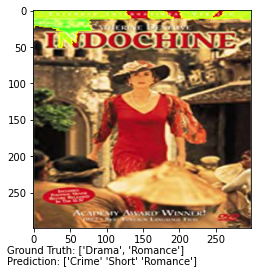

In [ ]:
# !pip install lime
data = trainLabelMovieMap.loc[trainLabelMovieMap.movieid == 104507]
print(data)

###helper functions for LIME
def get_pil_transform(): 
    transf = transforms.Compose([
        transforms.Resize((300, 300)),
        transforms.CenterCrop(299)
    ])    

    return transf

def get_preprocess_transform():
       
    transf = transforms.Compose([
        transforms.ToTensor(),transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225])
    ])    

    return transf    

pill_transf = get_pil_transform()
preprocess_transform = get_preprocess_transform()

def batch_predict(images):
    inception.eval()
    batch = torch.stack(tuple(preprocess_transform(i) for i in images), dim=0)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    inception.to(device)
    batch = batch.to(device)
    
    logits = inception(batch)
    probs = F.softmax(logits, dim=1)
    logits = torch.nn.functional.log_softmax(logits[0], dim=0)
    print(torch.topk(logits, 3).indices,torch.topk(logits, 3))
    return probs.detach().cpu().numpy()

from torchvision.datasets.folder import pil_loader

from lime import lime_image
explainer = lime_image.LimeImageExplainer()
explanation = explainer.explain_instance(np.array(pill_transf(pil_loader("/content/posters/"+str(data.movieid.values[0])+".jpg"))), 
                                         batch_predict, # classification function
                                         top_labels=3, 
                                         hide_color=0, 
                                         num_samples=1)
image = np.array(pill_transf(pil_loader("/content/posters/"+str(data.movieid.values[0])+".jpg")))
pred = inception(torch.stack(tuple([preprocess_transform(image)])).cuda())
pred = torch.nn.functional.log_softmax(pred[0], dim=0)
print(trainLabelMovieMap.columns[torch.topk(pred, 3).indices.cpu()])



# p = pil_loader("/content/posters/3.jpg")


from skimage.segmentation import mark_boundaries
temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True, num_features=5, hide_rest=False)
img_boundry1 = mark_boundaries(temp/255.0, mask)
# plt.imshow(img_boundry1)


temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=False, num_features=10, hide_rest=False)
img_boundry2 = mark_boundaries(temp/255.0, mask)
plt.imshow(img_boundry2)
plt.text(0.2, 0,"Ground Truth: "+data.Type.values[0]+"\nPrediction: " + str(trainLabelMovieMap.columns[torch.topk(pred, 2).indices.cpu()],transform=plt.gcf().transFigure)
# plt.text(0.2, 0,"Prediction: "+str(trainLabelMovieMap.columns[torch.topk(pred, 3).indices.cpu()]),transform=plt.gcf().transFigure)
plt.savefig(str(data.movieid.values[0])+".png")
plt.show()

In [ ]:
image = np.array(pill_transf(pil_loader("/content/posters/856778.jpg")))
logits = inception(torch.stack(tuple([preprocess_transform(image)])).cuda())
logits = torch.nn.functional.log_softmax(logits[0], dim=0)


print(torch.topk(logits, 3).indices,torch.topk(logits, 3))

tensor([ 8, 25, 17], device='cuda:0') torch.return_types.topk(
values=tensor([-1.4633, -1.7342, -2.4297], device='cuda:0', grad_fn=<TopkBackward0>),
indices=tensor([ 8, 25, 17], device='cuda:0'))


In [ ]:
trainLabelMovieMap.loc[trainLabelMovieMap.movieid == 856778].Type

23330    ['Crime', 'Drama']
Name: Type, dtype: object

In [ ]:
print(trainLabelMovieMap.columns[torch.topk(logits, 3).indices.cpu()])

['Crime' 'Sport' 'Music']


In [ ]:
#write a function that loads inception model using torch.load_state_dict() from /content/models dir

inception = models.resnet50()
num_ftrs = inception.fc.in_features#512
inception.fc = nn.Linear(num_ftrs,28) #(2048,28) we have 28 classes
inception.fc.requires_grad = True
inception.load_state_dict(torch.load("/content/models/resnet_acc_21.83219178082192_epoch_1_lr_0.0001.pt"))

inception = inception.cuda()


In [ ]:
###helper functions for LIME
def get_pil_transform(): 
    transf = transforms.Compose([
        transforms.Resize((300, 300)),
        transforms.CenterCrop(299)
    ])    

    return transf

def get_preprocess_transform():
       
    transf = transforms.Compose([
        transforms.ToTensor(),transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225])
    ])    

    return transf    

pill_transf = get_pil_transform()
preprocess_transform = get_preprocess_transform()

def batch_predict(images):
    inception.eval()
    batch = torch.stack(tuple(preprocess_transform(i) for i in images), dim=0)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    inception.to(device)
    batch = batch.to(device)
    
    logits = inception(batch)
    probs = F.softmax(logits, dim=1)
    return probs.detach().cpu().numpy()




In [ ]:
!pip install lime


     |████████████████████████████████| 275 kB 5.2 MB/s 
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283857 sha256=96408584b56f1fce586dd3033255b46333fc4662b84e4e5801ac52e2d903059f
  Stored in directory: /root/.cache/pip/wheels/ca/cb/e5/ac701e12d365a08917bf4c6171c0961bc880a8181359c66aa7
Successfully built lime


In [ ]:
from torchvision.datasets.folder import pil_loader

from lime import lime_image
explainer = lime_image.LimeImageExplainer()
explanation = explainer.explain_instance(np.array(pill_transf(pil_loader("/content/posters/3.jpg"))), 
                                         batch_predict, # classification function
                                         top_labels=3, 
                                         hide_color=0, 
                                         num_samples=1) 


  0%|          | 0/1 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_regression.py:796: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_regression.py:796: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_regression.py:796: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


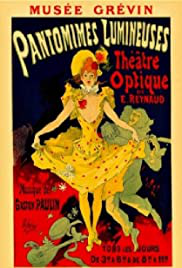

In [ ]:
p = pil_loader("/content/posters/3.jpg")
p

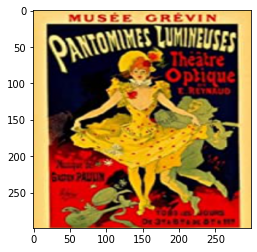

In [ ]:
from skimage.segmentation import mark_boundaries
temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True, num_features=5, hide_rest=False)
img_boundry1 = mark_boundaries(temp/255.0, mask)
plt.imshow(img_boundry1)

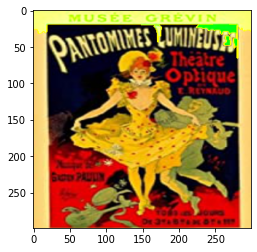

In [ ]:
temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=False, num_features=10, hide_rest=False)
img_boundry2 = mark_boundaries(temp/255.0, mask)
plt.imshow(img_boundry2)

In [ ]:
#test model on testloader
acc_test=0
loss_test=0
data_count_test = 0

for image,labels in testloader:
    data_count_test += len(labels)
    inception.eval()
    optimizer.zero_grad()
    image,labels= image.cuda(),labels.cuda()
    with torch.no_grad():
      logits = inception(image)
      logits = torch.nn.functional.log_softmax(logits, dim=0) #not needed for resnet
    loss = criterion(logits,labels.float())
    acc = sum([ 1 if (torch.topk(label.float(),3).indices == torch.topk(logit, 3).indices).float().sum()>0 else 0 for label,logit in zip(labels,logits) ])
    acc_test += acc/len(labels)
    # print(loss.item())
    loss_test += loss.item()/len(labels)

print("test accuracy", acc_test/len(testloader),"test loss",loss_test,"number of images", data_count_test)

test accuracy 0.38505824372759856 test loss 36.82424969610668 number of images 7199
